In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import pandas as pd
import configs

# Load ICL results

In [35]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "cntree"
env_name = "cntree_layers7_bprob0.9_corr0.25_state_dim10_envs300000_H800_explore"
#model_name = "transformer_end_query_embd512_layer4_head4_lr1e-05_drop0_batch256"
model_name = "transformer_end_query_embd512_layer3_head4_lr0.0001_drop0_batch256"
model_path = os.path.join(engram_dir, wandb_project, env_name, "models", model_name)
path_to_pkl = os.path.join(model_path, 'eval_results.pkl')


In [36]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
df = pd.DataFrame(data)
df.head()

,model,return,environment,experienced_reward,context_length,path_length_scaled,returns_scaled
40,Learner (temp=2),0.0,0,0,0,1.0,0.0
41,Learner (temp=2),0.0,1,0,0,1.0,0.0
42,Learner (temp=2),0.0,2,0,0,1.0,0.0
43,Learner (temp=2),0.0,3,0,0,1.0,0.0
44,Learner (temp=2),0.0,4,0,0,1.0,0.0


# Load DQN results

In [39]:
engram_dir = "/n/holylfs06/LABS/krajan_lab/Lab/cfang/icl-maze/"
wandb_project = "dqn_cntree"
env_name = "cntree_layers7_bprob1.0_corr0.25_state_dim10_envs1000_H1600_explore"
model_name = "dqn_nlayers4_gamma0.9_target10_lr1e-05_temp1.0"
path_to_pkl = os.path.join(engram_dir, wandb_project, env_name, "models", model_name, "eval_results.pkl")

In [40]:
with open(path_to_pkl, "rb") as f:
    data = pickle.load(f)
dqn_df = pd.DataFrame(data)
dqn_df = dqn_df.rename(columns={'returns': 'return'})
dqn_df['model'] = 'DQN'
opt_return = 389.1792
dqn_df['path_length_scaled'] = (opt_return - dqn_df['return'])/opt_return
dqn_df['returns_scaled'] = dqn_df['return']/opt_return
dqn_df.head()

,return,environment,experienced_reward,context_length,model,path_length_scaled,returns_scaled
0,0.0,0,0,10,DQN,1.000000,0.000000
1,0.3,0,0,25,DQN,0.999229,0.000771
2,4.0,0,0,50,DQN,0.989722,0.010278
3,0.0,0,0,75,DQN,1.000000,0.000000
4,0.0,0,0,100,DQN,1.000000,0.000000


In [41]:
# Concatenate the dataframes
df = pd.concat([df, dqn_df], ignore_index=True)


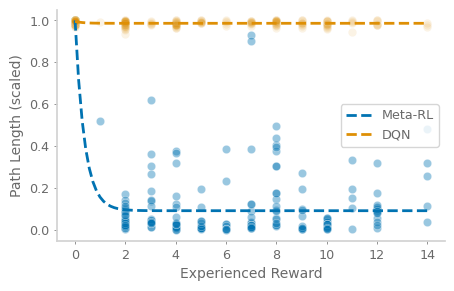

In [42]:
from scipy.optimize import curve_fit
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

rlim = 15
_df = df[df['experienced_reward'] < rlim]

fig, ax = plt.subplots(figsize=(5,3))
for model, model_name in zip(['Learner (temp=2)', 'DQN'], ['Meta-RL', 'DQN']):
    __df = _df[_df['model'] == model]
    alpha = 0.1 if model == 'DQN' else 0.4
    sns.scatterplot(
        data=__df, x='experienced_reward', y='path_length_scaled',
        ax=ax, alpha=alpha)
    x = __df['experienced_reward']
    y = __df['path_length_scaled']
    popt, _ = curve_fit(exp_func, x, y, p0=[1, 1e-3, 0])
    x_fit = np.linspace(x.min(), x.max(), 100)
    y_fit = exp_func(x_fit, *popt)
    ax.plot(x_fit, y_fit, '--', label=model_name, linewidth=2)
ax.legend()
plt.xlabel('Experienced Reward')
plt.ylabel('Path Length (scaled)')
plt.show()


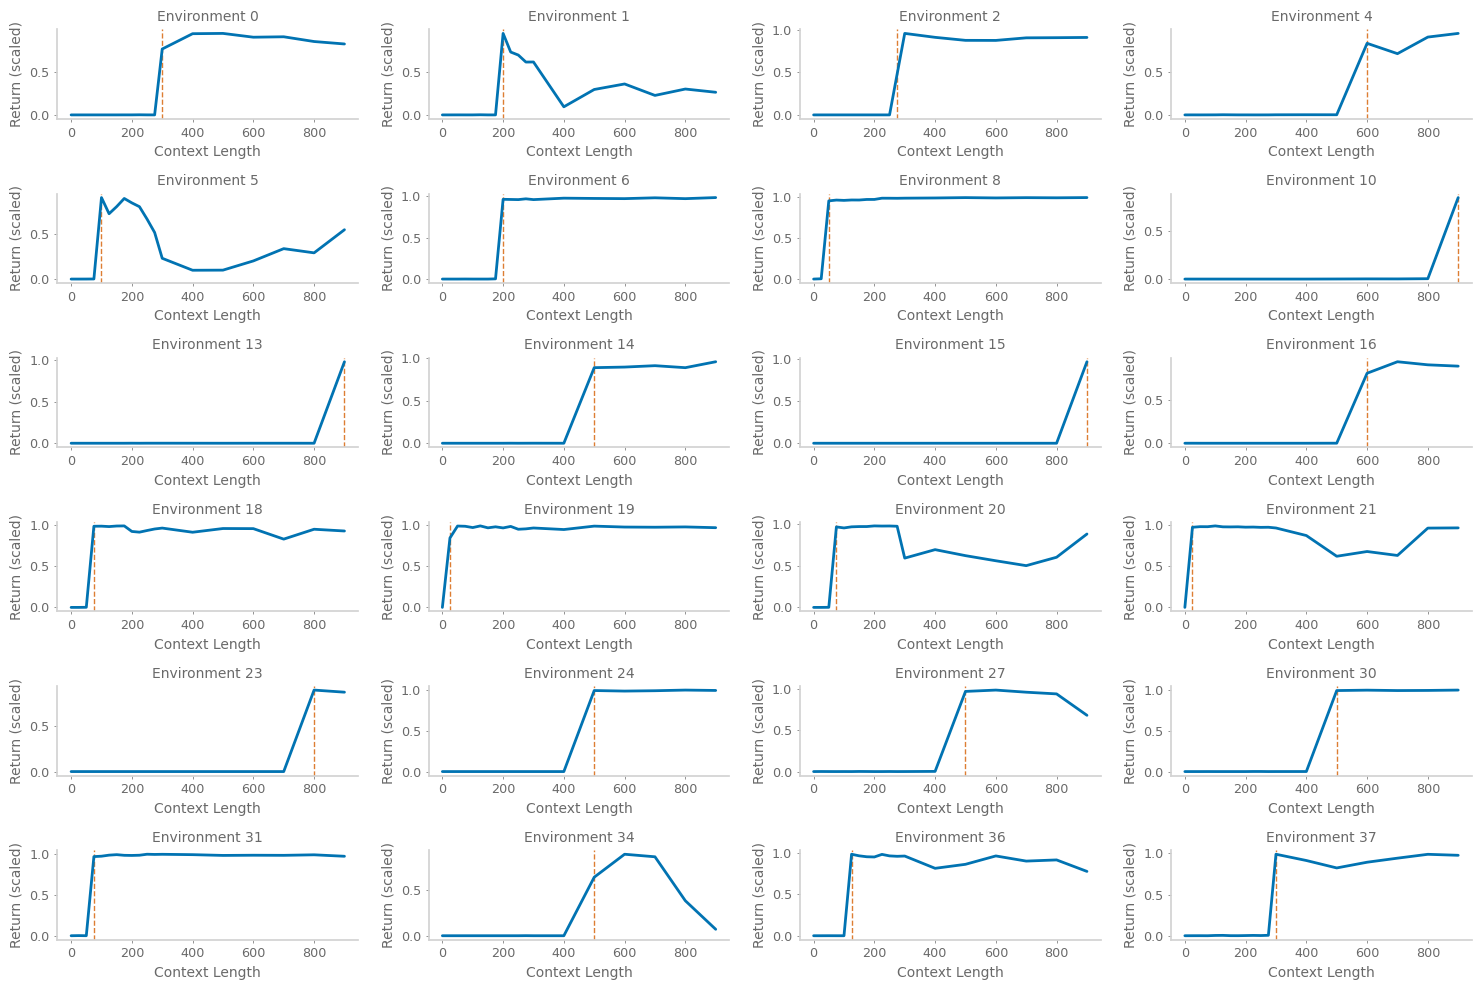

In [43]:
rlim = 30
_df = df[df['model'] == 'Learner (temp=2)']
_df = _df[_df['context_length'] < 1000]
sample_envs = _df['environment'].unique()

# Create 3x4 subplot grid
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()
n_envs_plotted = 0
n_envs_total = n_rows * n_cols
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    if pd.notna(first_reward) and first_reward < 1000:
        axes[n_envs_plotted].axvline(x=first_reward, color='r', linestyle='--', alpha=0.8)
    else:
        continue
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='returns_scaled',
        ax=axes[n_envs_plotted],
        linewidth=2
    )
    axes[n_envs_plotted].set_title(f'Environment {env}')
    axes[n_envs_plotted].set_xlabel('Context Length')
    axes[n_envs_plotted].set_ylabel('Return (scaled)')

    n_envs_plotted += 1
    if n_envs_plotted == n_envs_total:
        break

plt.tight_layout()
plt.show()


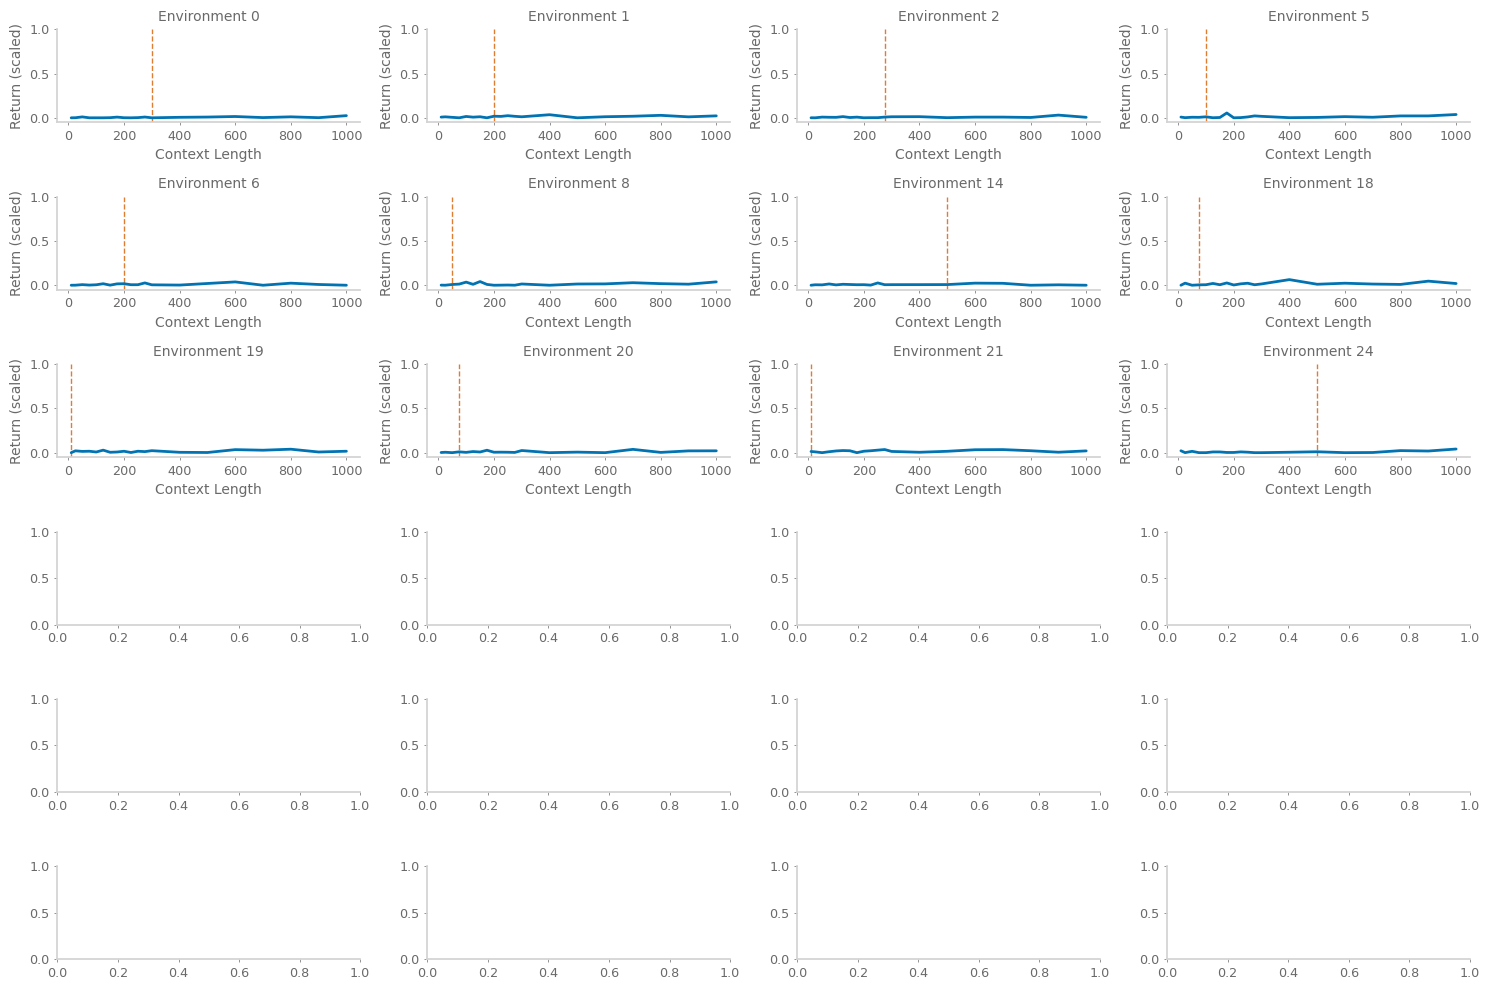

In [44]:
rlim = 30
_df = df[df['model'] == 'DQN']
sample_envs = _df['environment'].unique()

# Create 3x4 subplot grid
n_rows = 6
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()
n_envs_plotted = 0
n_envs_total = n_rows * n_cols
for env in sample_envs:
    env_df = _df[_df['environment'] == env]
    # Find first context length where reward > 0
    first_reward = env_df[env_df['experienced_reward'] > 0]['context_length'].min()
    if pd.notna(first_reward) and first_reward < 600:
        axes[n_envs_plotted].axvline(x=first_reward, color='r', linestyle='--', alpha=0.8)
    else:
        continue
    sns.lineplot(
        data=env_df,
        x='context_length',
        y='returns_scaled',
        ax=axes[n_envs_plotted],
        linewidth=2
    )
    axes[n_envs_plotted].set_title(f'Environment {env}')
    axes[n_envs_plotted].set_xlabel('Context Length')
    axes[n_envs_plotted].set_ylabel('Return (scaled)')
    axes[n_envs_plotted].set_ylim(-0.05, 1)
    n_envs_plotted += 1
    if n_envs_plotted == n_envs_total:
        break

plt.tight_layout()
plt.show()